In [4]:
## debug 2

# save_debug_frame.py

import cv2 as cv
import numpy as np
import pydicom
from skimage.morphology import skeletonize

# ---------------- HARD-CODED INPUT ----------------
DICOM_PATH = "/home/ds/Desktop/Hand_dicom/H007.dcm"
FRAME_NO   = 216
OUT_PATH   = "debug.png"
# --------------------------------------------------


# ---------- EXACTLY FROM YOUR FILTERING SCRIPT ----------
CLAHE_CLIP       = 2.0
CLAHE_TILE_GRIDS = (8, 8)
GAUSS_SIGMA_PX   = 1
MEDIAN_KSIZE     = 3

def to_uint8(image_):
    image_ = np.asanyarray(image_)
    if image_.dtype == np.uint8:
        return image_
    imin, imax = np.min(image_), np.max(image_)
    if imax <= imin:
        return np.zeros_like(image_, dtype=np.uint8)
    scaled = (image_ - imin) / (imax - imin)
    return (scaled * 255).astype(np.uint8)

def enhance_frame_only(frame, clip_limit=CLAHE_CLIP,
                       tile_grid_size=CLAHE_TILE_GRIDS,
                       sigma=GAUSS_SIGMA_PX):

    if frame.dtype != np.uint8:
        frame = to_uint8(frame)

    if MEDIAN_KSIZE and MEDIAN_KSIZE > 1:
        frame = cv.medianBlur(frame, MEDIAN_KSIZE)

    frame = cv.normalize(frame, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

    clahe = cv.createCLAHE(clipLimit=clip_limit,
                           tileGridSize=tile_grid_size)
    frame = clahe.apply(frame)

    if sigma and sigma > 0:
        k = max(1, int(2 * round(3 * sigma) + 1))
        frame = cv.GaussianBlur(frame, (k, k),
                                sigmaX=sigma, sigmaY=sigma)
    return frame
# -----------------------------------------------------------


# ================= AXIS TICKS ONLY (NO TEXT) =================
def draw_axes(img, tick_step=50):
    vis = img.copy()
    h, w = vis.shape[:2]

    # X-axis ticks (bottom)
    for x in range(0, w, tick_step):
        cv.line(vis, (x, h-10), (x, h), (0, 255, 0), 2)

    # Y-axis ticks (left)
    for y in range(0, h, tick_step):
        cv.line(vis, (0, y), (10, y), (0, 255, 0), 2)

    # Outer border
    cv.rectangle(vis, (0, 0), (w-1, h-1), (0, 255, 0), 1)

    return vis


def draw_roi_bounds(img, top_end, bottom_sta):
    vis = img.copy()
    h, w = vis.shape[:2]

    # ROI cut lines
    cv.line(vis, (0, top_end),     (w, top_end),     (255, 0, 0), 2)
    cv.line(vis, (0, bottom_sta), (w, bottom_sta),  (255, 0, 0), 2)

    return vis
# ============================================================


def main():
    ds = pydicom.dcmread(DICOM_PATH)
    arr = ds.pixel_array

    if arr.ndim == 2:
        arr = arr[None, ...]
    if arr.ndim == 4 and arr.shape[-1] > 1:
        arr = arr[..., 0]

    n_frames = arr.shape[0]

    if FRAME_NO < 1 or FRAME_NO > n_frames:
        print(f"[ERROR] Frame must be in range 1–{n_frames}")
        return

    raw = arr[FRAME_NO - 1]
    raw_u8 = to_uint8(raw)

    # === ENHANCED IMAGE ===
    enhanced = enhance_frame_only(raw)

    # === BINARIZATION ===
    _, binary = cv.threshold(
        enhanced, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
    )
    binary_bool = binary > 0

    # === SKELETONIZATION ===
    skeleton_std = skeletonize(binary_bool)
    skeleton_lee = skeletonize(binary_bool, method='lee')

    skel_std_u8 = (skeleton_std * 255).astype(np.uint8)
    skel_lee_u8 = (skeleton_lee * 255).astype(np.uint8)

    # === RGB CONVERSION ===
    raw_rgb      = cv.cvtColor(raw_u8, cv.COLOR_GRAY2RGB)
    enh_rgb      = cv.cvtColor(enhanced, cv.COLOR_GRAY2RGB)
    skel_std_rgb = cv.cvtColor(skel_std_u8, cv.COLOR_GRAY2RGB)
    skel_lee_rgb = cv.cvtColor(skel_lee_u8, cv.COLOR_GRAY2RGB)

    # ================= ROI DEFINITION =================
    h, w = raw_rgb.shape[:2]
    top_end    = int(0.30 * h)
    bottom_sta = int(0.90 * h)

    # Draw axes + ROI bounds on FULL image (for reference)
    raw_full  = draw_axes(draw_roi_bounds(raw_rgb, top_end, bottom_sta))
    enh_full  = draw_axes(draw_roi_bounds(enh_rgb, top_end, bottom_sta))
    skel_full = draw_axes(draw_roi_bounds(skel_std_rgb, top_end, bottom_sta))
    lee_full  = draw_axes(draw_roi_bounds(skel_lee_rgb, top_end, bottom_sta))

    # ================= ROI CROP (✅ FIXED HERE) =================
    def apply_roi(img):
        # KEEP ONLY the middle region (blue band)
        return img[top_end:bottom_sta, :]

    raw_roi  = draw_axes(apply_roi(raw_rgb))
    enh_roi  = draw_axes(apply_roi(enh_rgb))
    skel_roi = draw_axes(apply_roi(skel_std_rgb))
    lee_roi  = draw_axes(apply_roi(skel_lee_rgb))

    # === STACK FINAL DEBUG IMAGE ===
    debug_img = np.vstack([
        np.hstack([raw_full, enh_full, skel_full, lee_full]),
        np.hstack([raw_roi,  enh_roi,  skel_roi,  lee_roi ])
    ])

    cv.imwrite(OUT_PATH, debug_img)

    print("[OK] debug.png saved with AXES + ROI")
    print(" Frame     :", FRAME_NO, "/", n_frames)
    print(" Full Size :", raw_rgb.shape)
    print(" ROI Height:", raw_roi.shape[0])
    print(" Final Img :", debug_img.shape)
    print(" Output    :", OUT_PATH)


if __name__ == "__main__":
    main()

KeyboardInterrupt: 

In [ ]:
## debug3.py 

import os
import math
import numpy as np
import cv2 as cv
import pydicom

# ---------------- HARD CODED DEBUG VALUES ----------------
DICOM_PATH  = "/home/ds/Desktop/Hand_dicom/K04.dcm"   # change if needed
FRAME_INDEX = 114   # 1-based index
OUT_PATH    = "debug_hough.png"

# ---------------- LOAD DICOM ----------------
ds = pydicom.dcmread(DICOM_PATH)
arr = ds.pixel_array

if arr.ndim == 2:
    arr = arr[None, ...]
if arr.ndim == 4:
    arr = arr[..., 0]

n_frames = arr.shape[0]
if FRAME_INDEX < 1 or FRAME_INDEX > n_frames:
    raise ValueError(f"Invalid frame index {FRAME_INDEX}. Valid range is 1–{n_frames}")

frame = arr[FRAME_INDEX - 1]

# ---------------- CONVERT TO UINT8 ----------------
def to_uint8(image_):
    image_ = np.asanyarray(image_)
    if image_.dtype == np.uint8:
        return image_
    imin, imax = np.min(image_), np.max(image_)
    if imax <= imin:
        return np.zeros_like(image_, dtype=np.uint8)
    scaled = (image_ - imin) / (imax - imin)
    return (scaled * 255).astype(np.uint8)

src = to_uint8(frame)

# ---------------- CANNY ----------------
dst = cv.Canny(src, 50, 200, None, 3)

# Convert to BGR for drawing
cdst  = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
cdstP = cdst.copy()

# ---------------- STANDARD HOUGH (YOUR EXACT CODE) ----------------
lines = cv.HoughLines(dst, 1, np.pi / 180, 150)

std_count = 0
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        cv.line(cdst, pt1, pt2, (0, 0, 255), 2, cv.LINE_AA)
        std_count += 1

# ---------------- PROBABILISTIC HOUGH (YOUR EXACT CODE) ----------------
linesP = cv.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)

prob_count = 0
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (255, 0, 0), 2, cv.LINE_AA)
        prob_count += 1

# ---------------- SAVE IMAGE ----------------
combined = np.hstack([cdst, cdstP])
cv.imwrite(OUT_PATH, combined)

print("\n=== HOUGH DEBUG (RAW, UNFILTERED) ===")
print(f"DICOM        : {os.path.basename(DICOM_PATH)}")
print(f"Frame index  : {FRAME_INDEX}")
print(f"Image shape  : {src.shape}")
print(f"Std lines    : {std_count}  (RED)")
print(f"Prob lines   : {prob_count} (BLUE)")
print(f"Saved image  : {OUT_PATH}")

In [ ]:
### debug4.py 

import os
import math
import numpy as np
import cv2 as cv
import pydicom

# ---------------- HARD CODED DEBUG VALUES ----------------
DICOM_PATH = "/home/ds/Desktop/Hand_dicom/K04.dcm"   # change if needed
MAX_FRAMES = 100                                   # how many frames to scan
OUT_DIR    = "debug_hough_frames"                  # where images go
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- LOAD DICOM ----------------
ds = pydicom.dcmread(DICOM_PATH)
arr = ds.pixel_array

if arr.ndim == 2:
    arr = arr[None, ...]
if arr.ndim == 4:
    arr = arr[..., 0]

n_frames = arr.shape[0]
max_frames = min(MAX_FRAMES, n_frames)

# ---------------- CONVERT TO UINT8 ----------------
def to_uint8(image_):
    image_ = np.asanyarray(image_)
    if image_.dtype == np.uint8:
        return image_
    imin, imax = np.min(image_), np.max(image_)
    if imax <= imin:
        return np.zeros_like(image_, dtype=np.uint8)
    scaled = (image_ - imin) / (imax - imin)
    return (scaled * 255).astype(np.uint8)

print(f"\nScanning {os.path.basename(DICOM_PATH)}")
print(f"Using first {max_frames} / {n_frames} frames\n")

# ---------------- MAIN LOOP ----------------
for idx in range(max_frames):
    frame_index = idx + 1
    frame = arr[idx]
    src = to_uint8(frame)

    # ---------------- CANNY ----------------
    dst = cv.Canny(src, 50, 200, None, 3)

    # Convert to BGR for drawing
    cdst  = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
    cdstP = cdst.copy()

    # ---------------- STANDARD HOUGH ----------------
    lines = cv.HoughLines(dst, 1, np.pi / 180, 150)
    std_count = 0

    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
            pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
            cv.line(cdst, pt1, pt2, (0, 0, 255), 2, cv.LINE_AA)
            std_count += 1

    # ---------------- PROBABILISTIC HOUGH ----------------
    linesP = cv.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)
    prob_count = 0

    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (255, 0, 0), 2, cv.LINE_AA)
            prob_count += 1

    # ---------------- PRINT PER-FRAME SUMMARY ----------------
    print(f"Frame {frame_index:03d} | Std: {std_count:3d} | Prob: {prob_count:3d}")

    # ---------------- SAVE IMAGE ONLY IF SOMETHING IS DETECTED ----------------
    if std_count > 0 or prob_count > 0:
        combined = np.hstack([cdst, cdstP])
        out_path = os.path.join(OUT_DIR, f"frame_{frame_index:03d}.png")
        cv.imwrite(out_path, combined)

print("\n✅ Done. Debug images saved only for frames with detections.")



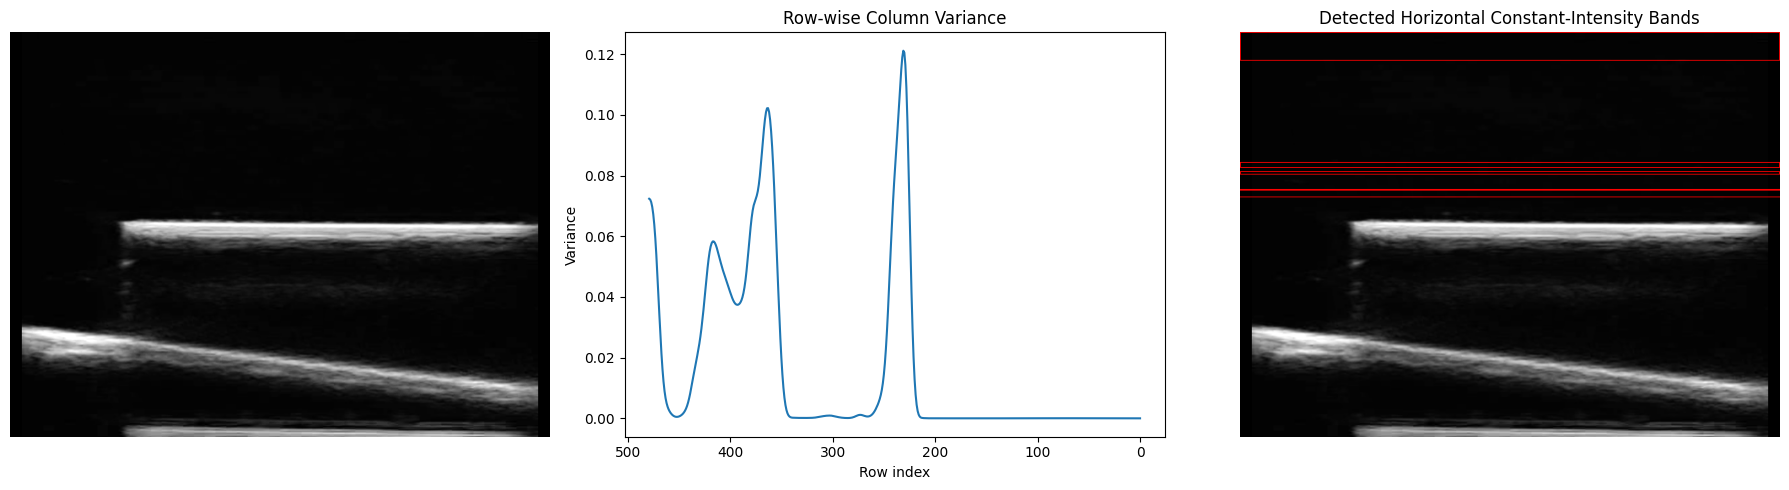

Detected bar row ranges (y):
[(0, 33), (154, 160), (165, 168), (186, 187), (195, 195)]


In [ ]:
import numpy as np
import cv2 as cv
import pydicom
import matplotlib.pyplot as plt

# ---------------- HARD SETTINGS ----------------
DICOM_PATH = "/home/ds/Desktop/Hand_dicom/K04.dcm"
FRAME_INDEX = 80   # 1-based

# ---------------- LOAD DICOM ----------------
ds = pydicom.dcmread(DICOM_PATH)
arr = ds.pixel_array

if arr.ndim == 2:
    arr = arr[None, ...]
if arr.ndim == 4:
    arr = arr[..., 0]

n_frames = arr.shape[0]
assert 1 <= FRAME_INDEX <= n_frames, "Invalid frame index"

frame = arr[FRAME_INDEX - 1].astype(np.float32)

# ---------------- NORMALIZE ----------------
fmin, fmax = frame.min(), frame.max()
frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

h, w = frame_n.shape

# ---------------- COLUMN-WISE VARIANCE PER ROW ----------------
# For each row: how much does intensity change as we go across columns?
row_var = np.var(frame_n, axis=1)

# Smooth the profile to suppress speckle noise
row_var_smooth = cv.GaussianBlur(row_var.reshape(-1,1), (1, 21), 0).ravel()

# ---------------- BAR DETECTION VIA LOW VARIANCE ----------------
# Bar → very LOW variance across columns
thr = np.percentile(row_var_smooth, 10)   # bottom 10% most constant rows
bar_rows = row_var_smooth < thr

# Group into contiguous row ranges
bar_runs = []
i = 0
while i < h:
    if not bar_rows[i]:
        i += 1
        continue
    j = i
    while j+1 < h and bar_rows[j+1]:
        j += 1
    bar_runs.append((i, j))
    i = j + 1

# ---------------- VISUALIZATION ----------------
overlay = cv.cvtColor((frame_n * 255).astype(np.uint8), cv.COLOR_GRAY2BGR)

for y1, y2 in bar_runs:
    cv.rectangle(overlay, (0, y1), (w-1, y2), (0, 0, 255), 1)

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.imshow(frame_n, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Row-wise Column Variance")
plt.plot(row_var_smooth)
plt.gca().invert_xaxis()
plt.xlabel("Row index")
plt.ylabel("Variance")

plt.subplot(1,3,3)
plt.title("Detected Horizontal Constant-Intensity Bands")
plt.imshow(overlay[..., ::-1])
plt.axis("off")

plt.tight_layout()
plt.show()

print("Detected bar row ranges (y):")
print(bar_runs)


In [ ]:
import numpy as np
import cv2 as cv
import pydicom
import matplotlib.pyplot as plt

# ---------------- SETTINGS ----------------
DICOM_PATH = "/home/ds/Desktop/Hand_dicom/K04.dcm"
START_F = 60
END_F   = 70    # inclusive

# ---------------- LOAD DICOM ----------------
ds = pydicom.dcmread(DICOM_PATH)
arr = ds.pixel_array

if arr.ndim == 2:
    arr = arr[None, ...]
if arr.ndim == 4:
    arr = arr[..., 0]

n_frames = arr.shape[0]
assert START_F >= 1 and END_F <= n_frames

# ---------------- FUNCTION ----------------
def analyze_frame(frame, frame_number):
    frame = frame.astype(np.float32)

    # normalize
    fmin, fmax = frame.min(), frame.max()
    frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

    h, w = frame.shape

    # variance across columns (per row)
    row_var = np.var(frame_n, axis=1)

    # smoothed (captures structures, avoids speckle noise)
    row_var_smooth = cv.GaussianBlur(row_var.reshape(-1,1), (1,21), 0).ravel()

    # threshold for “most constant rows”
    thr = np.percentile(row_var_smooth, 10)
    bar_rows = row_var_smooth < thr

    # find contiguous runs
    bar_runs = []
    i = 0
    while i < h:
        if not bar_rows[i]:
            i += 1
            continue
        j = i
        while j+1 < h and bar_rows[j+1]:
            j += 1
        bar_runs.append((i, j))
        i = j + 1

    # ---------------- PRINT DEBUG ----------------
    print(f"\n========== FRAME {frame_number} ==========")
    print(f"Rows classified as BAR (low variance): {bar_rows.sum()} rows")
    print(f"BAR row ranges: {bar_runs}")
    print("\nSampled row variance values (row_idx, variance, smoothed, is_bar):")

    for y in range(0, h, 20):  # print every 20th row to avoid flooding
        print(f"{y:03d} | raw={row_var[y]:.6f} | smooth={row_var_smooth[y]:.6f} | bar={bar_rows[y]}")

    # ---------------- OVERLAY VISUAL ----------------
    overlay = cv.cvtColor((frame_n * 255).astype(np.uint8), cv.COLOR_GRAY2BGR)
    for y1, y2 in bar_runs:
        cv.rectangle(overlay, (0, y1), (w-1, y2), (0,0,255), 1)

    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.title(f"Frame {frame_number}")
    plt.imshow(frame_n, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Row-wise Column Variance")
    plt.plot(row_var_smooth)
    plt.gca().invert_xaxis()
    plt.xlabel("Row index")
    plt.ylabel("Variance")

    plt.subplot(1,3,3)
    plt.title("Detected Constant-Intensity Bands")
    plt.imshow(overlay[..., ::-1])
    plt.axis("off")

    plt.show()

    return row_var, row_var_smooth, bar_rows, bar_runs


# ---------------- RUN FOR FRAMES 40–50 ----------------
results = {}

for f in range(START_F, END_F + 1):
    frame = arr[f - 1]
    results[f] = analyze_frame(frame, f)

In [ ]:
import numpy as np
import cv2 as cv
import pydicom
import pandas as pd

# ---------------- SETTINGS ----------------
DICOM_PATH = "/home/ds/Desktop/Hand_dicom/K04.dcm"
START_F = 10
END_F   = 86    # inclusive
OUT_CSV = "intensity_bar_debug_K04_10_86.csv"

# ---------------- LOAD DICOM ----------------
ds = pydicom.dcmread(DICOM_PATH)
arr = ds.pixel_array

if arr.ndim == 2:
    arr = arr[None, ...]
if arr.ndim == 4:
    arr = arr[..., 0]

n_frames = arr.shape[0]
assert START_F >= 1 and END_F <= n_frames

rows = []

for f in range(START_F, END_F + 1):
    frame = arr[f - 1].astype(np.float32)

    # normalize
    fmin, fmax = frame.min(), frame.max()
    frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

    # column-wise variance per row
    row_var = np.var(frame_n, axis=1)

    # smoothed
    row_var_smooth = cv.GaussianBlur(row_var.reshape(-1,1), (1,21), 0).ravel()

    # stats
    mean_v = float(row_var_smooth.mean())
    min_v  = float(row_var_smooth.min())
    p10_v  = float(np.percentile(row_var_smooth, 10))

    bar_rows = row_var_smooth < p10_v
    num_bar_rows = int(bar_rows.sum())

    # longest contiguous run
    max_run = 0
    i = 0
    h = len(bar_rows)
    while i < h:
        if not bar_rows[i]:
            i += 1
            continue
        j = i
        while j+1 < h and bar_rows[j+1]:
            j += 1
        max_run = max(max_run, j - i + 1)
        i = j + 1

    rows.append({
        "frame": f,
        "mean_var": mean_v,
        "min_var": min_v,
        "p10_var": p10_v,
        "num_bar_rows": num_bar_rows,
        "longest_bar_run_px": max_run,
    })

df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)

print("✅ Saved intensity debug to:", OUT_CSV)
print(df.head(10))

✅ Saved intensity debug to: intensity_bar_debug_K04_10_86.csv
   frame  mean_var   min_var   p10_var  num_bar_rows  longest_bar_run_px
0     10  0.006521  0.000006  0.000010            48                  32
1     11  0.011130  0.000006  0.000008            48                  29
2     12  0.015099  0.000006  0.000008            48                  23
3     13  0.016006  0.000006  0.000007            48                  24
4     14  0.016980  0.000006  0.000007            48                  30
5     15  0.017507  0.000006  0.000008            48                  33
6     16  0.016996  0.000006  0.000007            48                  36
7     17  0.017587  0.000006  0.000007            48                  34
8     18  0.016440  0.000006  0.000007            48                  32
9     19  0.017166  0.000006  0.000007            48                  18


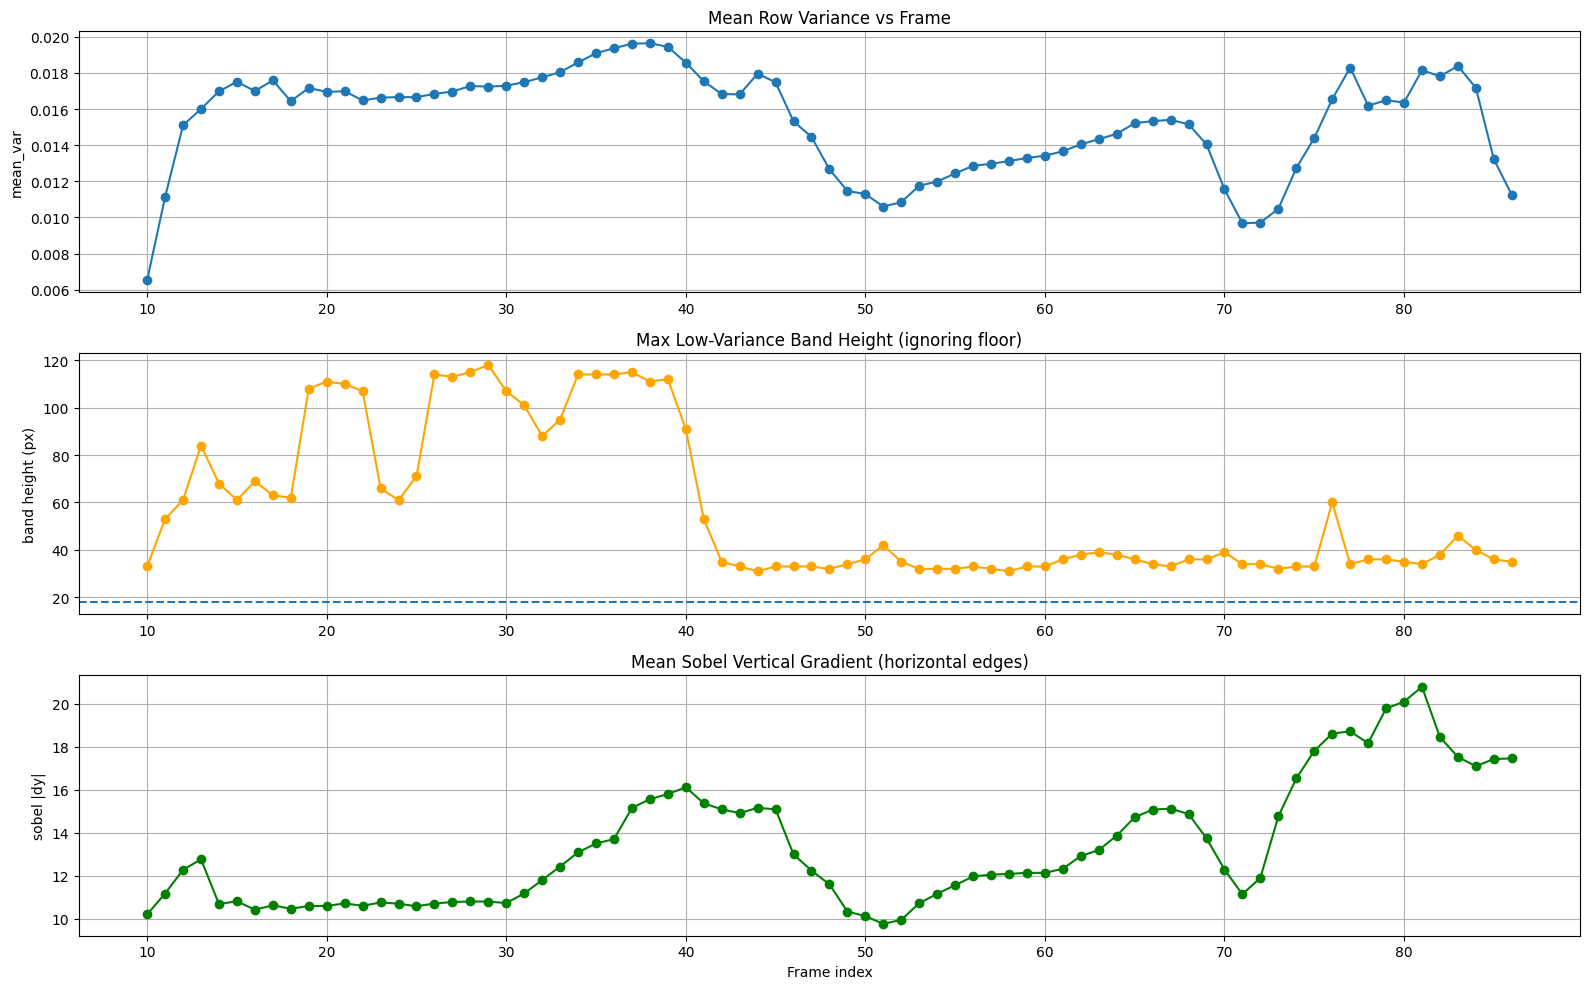


Frame | mean_var | band_px | sobel_dy
---------------------------------------
010   | 0.006521 |       33 | 10.20
011   | 0.011130 |       53 | 11.17
012   | 0.015099 |       61 | 12.27
013   | 0.016006 |       84 | 12.76
014   | 0.016980 |       68 | 10.68
015   | 0.017507 |       61 | 10.81
016   | 0.016996 |       69 | 10.41
017   | 0.017587 |       63 | 10.62
018   | 0.016440 |       62 | 10.46
019   | 0.017166 |      108 | 10.59
020   | 0.016949 |      111 | 10.59
021   | 0.016987 |      110 | 10.71
022   | 0.016476 |      107 | 10.60
023   | 0.016631 |       66 | 10.75
024   | 0.016659 |       61 | 10.70
025   | 0.016657 |       71 | 10.58
026   | 0.016835 |      114 | 10.70
027   | 0.016968 |      113 | 10.77
028   | 0.017275 |      115 | 10.80
029   | 0.017241 |      118 | 10.80
030   | 0.017290 |      107 | 10.73
031   | 0.017488 |      101 | 11.17
032   | 0.017753 |       88 | 11.80
033   | 0.018042 |       95 | 12.43
034   | 0.018579 |      114 | 13.09
035   | 0.019089 |   

In [ ]:
import numpy as np
import cv2 as cv
import pydicom
import matplotlib.pyplot as plt

# ---------------- SETTINGS ----------------
DICOM_PATH = "/home/ds/Desktop/Hand_dicom/K04.dcm"
START_F = 10
END_F   = 86

ABS_VAR_THR = 1.1e-05     # we will VERIFY this via plots
MIN_BAND_PX = 18
BOTTOM_FRAC_IGNORE = 0.15

# ---------------- LOAD DICOM ----------------
ds = pydicom.dcmread(DICOM_PATH)
arr = ds.pixel_array

if arr.ndim == 2:
    arr = arr[None, ...]
if arr.ndim == 4:
    arr = arr[..., 0]

H, W = arr.shape[1], arr.shape[2]
BOTTOM_Y = int((1.0 - BOTTOM_FRAC_IGNORE) * H)

frames = []
mean_vars = []
band_heights = []
sobel_edges = []

# ---------------- ANALYZE FRAMES ----------------
for f in range(START_F, END_F + 1):
    frame = arr[f - 1].astype(np.float32)

    # normalize
    fmin, fmax = frame.min(), frame.max()
    frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

    # --- ROW VARIANCE ---
    row_var = np.var(frame_n, axis=1)
    row_var_smooth = cv.GaussianBlur(row_var.reshape(-1,1), (1,21), 0).ravel()

    mean_vars.append(float(row_var_smooth.mean()))

    # --- LOW-VAR BANDS (ABS) ---
    low_var_rows = row_var_smooth < ABS_VAR_THR

    bands = []
    i = 0
    while i < H:
        if not low_var_rows[i]:
            i += 1
            continue
        j = i
        while j+1 < H and low_var_rows[j+1]:
            j += 1
        bands.append((i, j))
        i = j + 1

    max_valid_band = 0
    for y1, y2 in bands:
        height = y2 - y1 + 1
        center_y = (y1 + y2) // 2

        if center_y < BOTTOM_Y:   # ignore floor
            max_valid_band = max(max_valid_band, height)

    band_heights.append(max_valid_band)

    # --- SOBEL HORIZONTAL EDGE STRENGTH ---
    f8 = (frame_n * 255).astype(np.uint8)
    gy = cv.Sobel(f8, cv.CV_32F, 0, 1, ksize=3)
    sobel_strength = float(np.mean(np.abs(gy)))
    sobel_edges.append(sobel_strength)

    frames.append(f)

# ---------------- PLOTS ----------------
plt.figure(figsize=(16,10))

plt.subplot(3,1,1)
plt.plot(frames, mean_vars, marker="o")
plt.title("Mean Row Variance vs Frame")
plt.ylabel("mean_var")
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(frames, band_heights, marker="o", color="orange")
plt.axhline(MIN_BAND_PX, linestyle="--")
plt.title("Max Low-Variance Band Height (ignoring floor)")
plt.ylabel("band height (px)")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(frames, sobel_edges, marker="o", color="green")
plt.title("Mean Sobel Vertical Gradient (horizontal edges)")
plt.ylabel("sobel |dy|")
plt.xlabel("Frame index")
plt.grid(True)

plt.tight_layout()
plt.show()

# ---------------- PRINT TABLE ----------------
print("\nFrame | mean_var | band_px | sobel_dy")
print("---------------------------------------")
for i in range(len(frames)):
    print(f"{frames[i]:03d}   | {mean_vars[i]:.6f} | {band_heights[i]:8d} | {sobel_edges[i]:.2f}")


In [ ]:
import numpy as np
import cv2 as cv
import pydicom

# ---------------- SETTINGS ----------------
DICOM_PATH = "/home/ds/Desktop/Hand_dicom/K02.dcm"
START_F = 1
END_F   = 195

ABS_VAR_THR = 1.1e-05
BOTTOM_FRAC_IGNORE = 0.15

# thresholds tuned from your K04 curves
BAND_THR_PX      = 55      # thick band = bar1-type
MEAN_VAR_THR_B2  = 0.016   # bar2 mean_var
SOBEL_THR_B2     = 17.0    # bar2 sobel
MIN_SEG_LEN      = 3       # min frames to keep a bar segment
EXPAND_MARGIN    = 8       # expand each bar segment by this many frames on each side

# ---------------- LOAD DICOM ----------------
ds = pydicom.dcmread(DICOM_PATH)
arr = ds.pixel_array

if arr.ndim == 2:
    arr = arr[None, ...]
if arr.ndim == 4:
    arr = arr[..., 0]

H, W = arr.shape[1], arr.shape[2]
BOTTOM_Y = int((1.0 - BOTTOM_FRAC_IGNORE) * H)

frames   = list(range(START_F, END_F + 1))
mean_var_arr = []
band_px_arr  = []
sobel_arr    = []

# ---- 1) compute features for all frames ----
for f in frames:
    frame = arr[f - 1].astype(np.float32)

    # normalize
    fmin, fmax = frame.min(), frame.max()
    frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

    # row variance
    row_var = np.var(frame_n, axis=1)
    row_var_smooth = cv.GaussianBlur(row_var.reshape(-1,1), (1,21), 0).ravel()
    mean_v = float(row_var_smooth.mean())

    # low-var rows (absolute)
    low_var_rows = row_var_smooth < ABS_VAR_THR
    bands = []
    i = 0
    while i < H:
        if not low_var_rows[i]:
            i += 1
            continue
        j = i
        while j + 1 < H and low_var_rows[j + 1]:
            j += 1
        bands.append((i, j))
        i = j + 1

    max_valid_band = 0
    for y1, y2 in bands:
        h_band = y2 - y1 + 1
        center_y = (y1 + y2) // 2
        if center_y < BOTTOM_Y:   # ignore floor
            max_valid_band = max(max_valid_band, h_band)

    # Sobel vertical gradient = horizontal edges
    f8 = (frame_n * 255).astype(np.uint8)
    gy = cv.Sobel(f8, cv.CV_32F, 0, 1, ksize=3)
    sobel_dy = float(np.mean(np.abs(gy)))

    mean_var_arr.append(mean_v)
    band_px_arr.append(max_valid_band)
    sobel_arr.append(sobel_dy)

# ---- 2) apply Rule A + Rule B to get BAR candidates ----
n = len(frames)
bar_cand = np.zeros(n, dtype=bool)

for i in range(n):
    mv = mean_var_arr[i]
    bp = band_px_arr[i]
    sd = sobel_arr[i]

    ruleA = (bp >= BAND_THR_PX)  # bar1 type
    ruleB = (mv >= MEAN_VAR_THR_B2 and sd >= SOBEL_THR_B2)  # strong bar2
    ruleC = (mv >= 0.014 and sd >= 14.0)  # transitional bar2 (new)
    ruleD = (mv < 0.012 and sd < 13)

    bar = (ruleA or ruleB or ruleC)
    
    if ruleD:
        bar = False
    bar_cand[i] = bar

# ---- 3) temporal cleanup: drop very short segments ----
def runs_from_mask(mask):
    runs = []
    i = 0
    n = len(mask)
    while i < n:
        if not mask[i]:
            i += 1
            continue
        j = i
        while j + 1 < n and mask[j + 1]:
            j += 1
        runs.append((i, j))
        i = j + 1
    return runs

runs = runs_from_mask(bar_cand)
kept_runs = []
for a, b in runs:
    length = b - a + 1
    if length >= MIN_SEG_LEN:
        kept_runs.append((a, b))

# ---- 4) expand segments by margin ----
final_mask = np.zeros(n, dtype=bool)
for a, b in kept_runs:
    aa = max(0, a - EXPAND_MARGIN)
    bb = min(n - 1, b + EXPAND_MARGIN)
    final_mask[aa:bb+1] = True

# ---- 5) convert final_mask to intervals ----
final_runs = runs_from_mask(final_mask)

print("\nFrame | Label | mean_var | band_px | sobel_dy")
print("------------------------------------------------")
for i, f in enumerate(frames):
    lab = "BAR" if final_mask[i] else "BONE"
    print(f"{f:03d}   | {lab:4s} | {mean_var_arr[i]:.6f} | {band_px_arr[i]:7d} | {sobel_arr[i]:7.2f}")

print("\n Predicted Intervals (after smoothing):")
for (a, b) in final_runs:
    s = frames[a]
    e = frames[b]
    print(f"BAR : {s} → {e}")



Frame | Label | mean_var | band_px | sobel_dy
------------------------------------------------
001   | BONE | 0.001580 |      37 |    5.30
002   | BONE | 0.001580 |      37 |    5.31
003   | BONE | 0.001540 |      34 |    5.33
004   | BONE | 0.001536 |      48 |    5.34
005   | BONE | 0.001533 |      47 |    5.37
006   | BONE | 0.001492 |      36 |    5.46
007   | BONE | 0.001494 |      36 |    5.44
008   | BONE | 0.001494 |      73 |    5.48
009   | BONE | 0.001471 |      66 |    5.55
010   | BONE | 0.001472 |      66 |    5.57
011   | BONE | 0.001474 |      71 |    5.62
012   | BONE | 0.001475 |      38 |    5.81
013   | BONE | 0.001488 |      29 |    5.90
014   | BAR  | 0.001517 |      28 |    6.03
015   | BAR  | 0.001817 |      29 |    6.99
016   | BAR  | 0.002278 |      59 |    7.55
017   | BAR  | 0.003422 |      47 |    8.48
018   | BAR  | 0.007605 |      41 |   10.11
019   | BAR  | 0.012675 |      57 |   11.75
020   | BAR  | 0.014945 |      47 |   12.44
021   | BAR  | 0.016300 


===== BONE INTERVAL FRAME SCORES (DEBUG) =====

Bone 1: frames 33–73
frame | energy | edgeD | score
   33 | 0.0214 | 0.0080 | 0.00017
   34 | 0.0256 | 0.0087 | 0.00022
   35 | 0.0290 | 0.0125 | 0.00036
   36 | 0.0334 | 0.0120 | 0.00040
   37 | 0.0395 | 0.0131 | 0.00052
   38 | 0.0452 | 0.0168 | 0.00076
   39 | 0.0501 | 0.0191 | 0.00096
   40 | 0.0573 | 0.0188 | 0.00108
   41 | 0.0638 | 0.0177 | 0.00113
   42 | 0.0716 | 0.0184 | 0.00132
   43 | 0.0859 | 0.0284 | 0.00244
   44 | 0.0990 | 0.0398 | 0.00394
   45 | 0.1039 | 0.0447 | 0.00464
   46 | 0.1032 | 0.0425 | 0.00439
   47 | 0.1004 | 0.0460 | 0.00462
   48 | 0.0930 | 0.0426 | 0.00396
   49 | 0.0852 | 0.0358 | 0.00305
   50 | 0.0810 | 0.0359 | 0.00290
   51 | 0.0790 | 0.0367 | 0.00290
   52 | 0.0812 | 0.0376 | 0.00305
   53 | 0.0851 | 0.0429 | 0.00365
   54 | 0.0862 | 0.0459 | 0.00396
   55 | 0.0882 | 0.0460 | 0.00406
   56 | 0.0898 | 0.0496 | 0.00445
   57 | 0.0903 | 0.0485 | 0.00437
   58 | 0.0908 | 0.0486 | 0.00441
   59 | 0.0912 

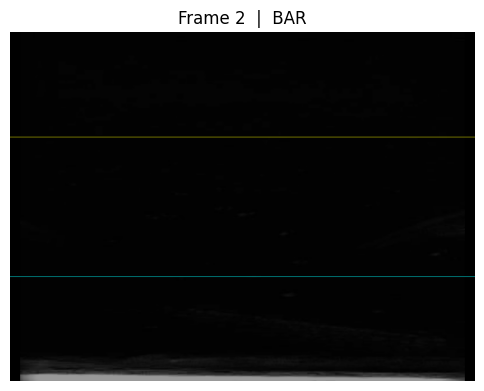

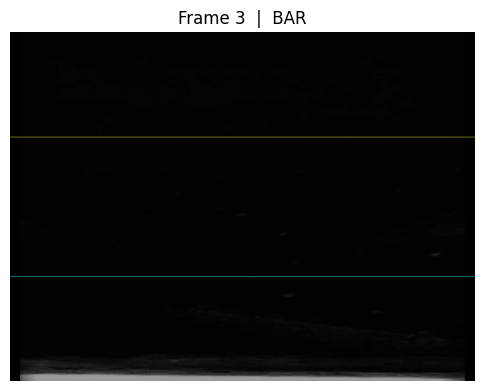

****************************
subject name -- K04
****************************

Detected BAR-1 intervals:
BAR 1 : 1 to 32
BAR 2 : 74 to 85
BAR 3 : 123 to 141
BAR 4 : 189 to 254
BAR 5 : 261 to 283
BAR 6 : 339 to 350

Detected Bone intervals:
Bone 1 : 33 - 73
Bone 2 : 86 - 122
Bone 3 : 142 - 188
Bone 4 : 255 - 260
Bone 5 : 284 - 338


In [ ]:
# debug_energy_intervals.py
import numpy as np
import cv2 as cv
import pydicom
import matplotlib.pyplot as plt
import os

def edge_density(roi, low=50, high=150):
    roi_u8 = (roi * 255).astype(np.uint8)
    edges = cv.Canny(roi_u8, low, high)
    return float(np.count_nonzero(edges)) / edges.size

def pick_best_frame_from_bone_interval(arr, bone_interval,
                                       roi_top_frac=0.30,
                                       roi_bottom_frac=0.70):
    """
    Select best frame inside a bone interval using
    energy * edge density peak.
    
    arr : np.ndarray [N,H,W]
    bone_interval : (start_frame, end_frame)  (1-based, inclusive)
    """

    s, e = bone_interval
    s0, e0 = s - 1, e - 1   # to 0-based

    H, W = arr.shape[1], arr.shape[2]
    roi_y1 = int(roi_top_frac * H)
    roi_y2 = int(roi_bottom_frac * H)

    best_score = -1
    best_frame = None

    for f in range(s0, e0 + 1):
        frame = arr[f].astype(np.float32)

        # normalize
        fmin, fmax = frame.min(), frame.max()
        frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

        roi = frame_n[roi_y1:roi_y2, :]

        energy = float(np.mean(roi))
        eD = edge_density(roi)

        score = energy * eD

        if score > best_score:
            best_score = score
            best_frame = f + 1   # back to 1-based

    return best_frame

def detect_bar1_regions_debug(dicom_path,
                              start_f=1,
                              end_f=350,
                              roi_top_frac=0.30,
                              roi_bottom_frac=0.70,
                              bright_ratio=0.55,
                              width_ratio=0.40,
                              smooth_len=4,
                              show_frames=[x for x in range(2,4)]):
    """
    Standalone Bar-1 detector.
    NO SAVING. Notebook-friendly visualization.
    """

    ds = pydicom.dcmread(dicom_path)
    arr = ds.pixel_array

    # Normalize to [N,H,W]
    if arr.ndim == 2:
        arr = arr[None, ...]
    if arr.ndim == 4:
        arr = arr[..., 0]

    N = arr.shape[0]
    #end_f = min(end_f, N)
    if end_f is None:
        end_f = N
    else:
        end_f = min(end_f, N)

    frames = range(start_f - 1, end_f)

    bar_mask = np.zeros(len(frames), dtype=bool)
    # ---- COLLECT FRAME SIGNALS (NO BAR DECISION HERE) ----
    signals = { "width_ratio": [], "edgeD": [], "energy": []}

    H, W = arr.shape[1], arr.shape[2]
    roi_y1 = int(roi_top_frac * H)
    roi_y2 = int(roi_bottom_frac * H)

    #print("\nFrame | max_run | thresh | BAR")
    #print("--------------------------------")

    vis_data = {}
    prev_roi_energy = None

    for idx, f in enumerate(frames):
        frame = arr[f].astype(np.float32)

        # Normalize intensity
        fmin, fmax = frame.min(), frame.max()
        frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

        roi = frame_n[roi_y1:roi_y2, :]

        # ----- NEW: detect empty ROI -----
        roi_energy = np.mean(roi)

        if roi_energy < 0.015:   # you can tune to 0.015–0.03
            is_bar = True
            max_run = 0
            vis_mask = np.zeros_like(roi, dtype=np.uint8)
            # ---- IMPORTANT: KEEP SIGNAL LENGTH CONSISTENT ----
            signals["width_ratio"].append(1.0)   # bars dominate width
            signals["edgeD"].append(0.0)          # smooth
            signals["energy"].append(roi_energy)

            bar_mask[idx] = True
            #print(f"{f+1:03d}   |  EMPTY ROI |   -   | True")
            
            if (f+1) in show_frames:
                vis_data[f+1] = (frame_n, vis_mask, bar_mask[idx])
            continue

        # Dynamic brightness threshold
        thr = bright_ratio * np.max(roi)

        # Compute max contiguous width of bright region
        max_run = 0
        vis_mask = np.zeros_like(roi, dtype=np.uint8)

        for r in range(roi.shape[0]):
            row = roi[r] > thr
            run_len = 0

            for j in range(W):
                if row[j]:
                    run_len += 1
                    vis_mask[r, j] = 255
                    max_run = max(max_run, run_len)
                else:
                    run_len = 0

        if prev_roi_energy is None:
            dE = 0
        else:
            dE = roi_energy - prev_roi_energy
        
        prev_roi_energy = roi_energy
        # --- edge density ---
        edgeD = edge_density(roi)
        
        #is_bar = max_run >= width_ratio * W
        #is_bar = (max_run >= width_ratio * W) and (thr > 0.50)
        roi_mean   = float(np.mean(roi))
        roi_std    = float(np.std(roi))
        roi_max    = float(np.max(roi))
        roi_p95    = float(np.percentile(roi, 95))
        roi_energy = roi_mean

        bright_ratio_used = thr / roi_max if roi_max > 0 else 0
        width_ratio_used  = max_run / W

        #EDGE_THR = 0.03      # bars are smooth
        #DE_THR   = 0.002     # small positive allowed

        #is_bar = (max_run >= width_ratio * W) and (thr >= 0.52) and (max_run >= 300) and (edgeD <= EDGE_THR) and (dE <= DE_THR)
        #bar_mask[idx] = is_bar
        
        signals["width_ratio"].append(max_run / W)
        signals["edgeD"].append(edgeD)
        signals["energy"].append(roi_energy)

        # TEMP placeholder (real bar decision later)
        is_bar_candidate = (max_run / W) >= 0.55 and (thr >= 0.45)
        bar_mask[idx] = is_bar_candidate

        #print(f"{f+1:03d} | run={max_run:4d} {width_ratio_used:.2f} | thr={thr:.3f} | dE={dE:+.3f}| p95={roi_p95:.3f} | energy={roi_energy:.3f} | mean={roi_mean:.3f} | edgeD={edgeD:.3f} | std={roi_std:.3f} | BAR={bar_mask[idx]}")

        if (f+1) in show_frames:
            vis_data[f+1] = (frame_n, vis_mask, bar_mask[idx])

    # =====================================================
    # SUBJECT-RELATIVE BAR DECISION (CRITICAL FIX)
    # =====================================================

    widths = np.array(signals["width_ratio"])
    edges  = np.array(signals["edgeD"])
    energy = np.array(signals["energy"])

    # Robust normalization (subject-relative)
    w_med = np.median(widths)
    w_mad = np.median(np.abs(widths - w_med)) + 1e-6

    e_med = np.median(edges)
    e_mad = np.median(np.abs(edges - e_med)) + 1e-6

    width_z = (widths - w_med) / w_mad
    edge_z  = (edges  - e_med) / e_mad

    # Temporal smoothness (bars are temporally smooth)
    energy_std = np.array([
        np.std(energy[max(0,i-3):min(len(energy),i+4)])
        for i in range(len(energy))
    ])

    # FINAL BAR DECISION (SUBJECT-INVARIANT)
    L = min(len(bar_mask), len(widths))
    for i in range(L):
        if bar_mask[i]:
            continue
        if (
            widths[i] >= 0.55 and          # YOUR HARD INVARIANT
            width_z[i] > 0.6 and           # dominant structure
            edge_z[i] < 0 and           # smoother than bone
            energy_std[i] < np.median(energy_std)
        ):
            bar_mask[i] = True

    # ------------------------------------------
    #  TEMPORAL REPAIR PIPELINE (C)
    # ------------------------------------------

    raw = bar_mask.copy()
    N = len(raw)

    # T1 — Neighbor fill (1 0 1 → 1 1 1)
    filled = raw.copy()
    for i in range(1, N-1):
        if raw[i] == 0 and raw[i-1] == 1 and raw[i+1] == 1:
            filled[i] = 1

    # T2 — Temporal dilation (expand ±3)
    dilated = filled.copy()
    dilation_radius = 3
    for i in range(N):
        if filled[i]:
            left  = max(0, i - dilation_radius)
            right = min(N-1, i + dilation_radius)
            dilated[left:right+1] = True

    # T3 — Remove micro-bursts (<5 frames)
    clean = dilated.copy()

    # detect continuous segments
    segments = []
    i = 0
    while i < N:
        if clean[i] == 0:
            i += 1
            continue
        j = i
        while j+1 < N and clean[j+1] == 1:
            j += 1
        length = j - i + 1
        if length < 5:           # remove tiny noisy bars
            clean[i:j+1] = 0
        else:
            segments.append((i, j))
        i = j + 1

    # this is the final bar mask
    bar_mask_final = clean


    # ---- Convert to intervals (FINAL MASK) ----
    intervals = []
    i = 0
    while i < len(bar_mask_final):
        if not bar_mask_final[i]:
            i += 1
            continue
        j = i
        while j + 1 < len(bar_mask_final) and bar_mask_final[j+1]:
            j += 1
        intervals.append((frames[i] + 1, frames[j] + 1))
        i = j + 1
    
    # -------- COMPUTE BONE INTERVALS --------
    bone_intervals = []
    for i in range(len(intervals) - 1):
        bar_end    = intervals[i][1]
        next_start = intervals[i+1][0]

        bone_s = bar_end + 1
        bone_e = next_start - 1

        if bone_s <= bone_e:
            bone_intervals.append((bone_s, bone_e))


    print("\n===== BONE INTERVAL FRAME SCORES (DEBUG) =====")

    for b_id, (s, e) in enumerate(bone_intervals, 1):
        print(f"\nBone {b_id}: frames {s}–{e}")
        print("frame | energy | edgeD | score")

        scores = []

        for f in range(s-1, e):  # 0-based
            frame = arr[f].astype(np.float32)

            fmin, fmax = frame.min(), frame.max()
            frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

            roi = frame_n[roi_y1:roi_y2, :]

            energy = float(np.mean(roi))
            eD = edge_density(roi)
            score = energy * eD

            scores.append(score)

            print(f"{f+1:5d} | {energy:6.4f} | {eD:6.4f} | {score:7.5f}")

        # -----------------------------------------
        # ONSET-BASED FRAME SELECTION (CORRECT)
        # -----------------------------------------

        scores = np.array(scores)
        peak_idx = np.argmax(scores)
        peak_frame = s + peak_idx

        score_norm = scores / (scores.max() + 1e-8)

        ONSET_THR = 0.65
        SUSTAIN_K = 5

        selected_frame = None
        method = "onset_sustain"

        for i in range(len(score_norm) - SUSTAIN_K):
            if np.all(score_norm[i:i + SUSTAIN_K] >= ONSET_THR):
                selected_frame = s + i
                break

        if selected_frame is None:
            selected_frame = peak_frame
            method = "peak_fallback"

        print(f"--> Peak score at frame {peak_frame}")
        print(f"--> Selected frame ({method}) = {selected_frame}")
        print(f"--> Window: [{max(s, selected_frame-15)} , {min(e, selected_frame+15)}]")


    # -------- SHOW VISUAL DEBUG --------
    for fnum, (frame_n, vis_mask, is_bar) in vis_data.items():
        plt.figure(figsize=(6, 6))
        plt.title(f"Frame {fnum}  |  {'BAR' if is_bar else 'BONE'}")

        vis = cv.cvtColor((frame_n * 255).astype(np.uint8), cv.COLOR_GRAY2RGB)

        # ROI boundaries
        vis[roi_y1, :, :] = [255, 255, 0]   # top ROI boundary
        vis[roi_y2, :, :] = [0, 255, 255]   # bottom ROI boundary

        # Overlay bright mask
        mask_rgb = np.zeros_like(vis)
        mask_rgb[roi_y1:roi_y2][vis_mask == 255] = [255, 0, 0]

        overlay = cv.addWeighted(vis, 0.6, mask_rgb, 0.8, 0)
        plt.imshow(overlay)
        plt.axis("off")
        plt.show()

    return bar_mask_final, intervals, bone_intervals, arr

dicom_path = "/home/ds/Desktop/Hand_dicom/K04.dcm"
subject_name =  os.path.splitext(os.path.basename(dicom_path))[0]

mask, ivals, bone_intervals, arr = detect_bar1_regions_debug(dicom_path)

print("****************************")
print(f"subject name -- {subject_name}")
print("****************************")   
print("\nDetected BAR-1 intervals:")

# Numbered BAR intervals
for idx, (s, e) in enumerate(ivals, start=1):
    print(f"BAR {idx} : {s} to {e}")

# -------- COMPUTE BONE INTERVALS --------
print("\nDetected Bone intervals:")

bone_id = 1
for i in range(len(ivals) - 1):
    bar_end   = ivals[i][1]
    next_start = ivals[i+1][0]

    bone_s = bar_end + 1
    bone_e = next_start - 1

    if bone_s <= bone_e:
        print(f"Bone {bone_id} : {bone_s} - {bone_e}")
        bone_id += 1


Bone interval | bone frames interval
38-78 | 49-69
89-115 | 97-115
125-148 | 129-148
221-265 | 233-253
277-328 | 299-319


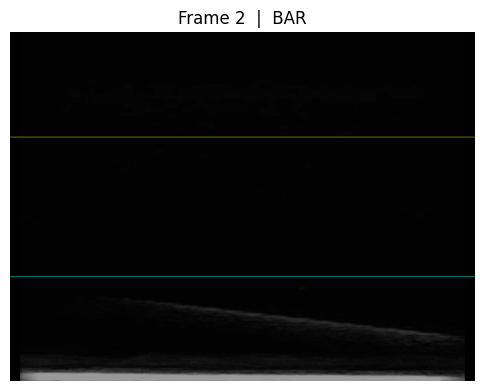

****************************
subject name -- K12
****************************

Detected BAR-1 intervals:
BAR 1 : 1 to 37
BAR 2 : 79 to 88
BAR 3 : 116 to 124
BAR 4 : 149 to 220
BAR 5 : 266 to 276
BAR 6 : 329 to 350

Detected Bone intervals:
Bone 1 : 38 to 78
Bone 2 : 89 to 115
Bone 3 : 125 to 148
Bone 4 : 221 to 265
Bone 5 : 277 to 328


In [ ]:
import numpy as np
import cv2 as cv
import pydicom
import matplotlib.pyplot as plt
import os


def analyze_bone_interval(arr, bone_interval,
                          roi_y1, roi_y2,
                          sustain_k=5,
                          onset_frac=0.65):
    """
    Analyze one bone interval and find onset-based bone frame
    """

    s, e = bone_interval
    scores = []

    print(f"\nBone interval {s}–{e}")
    print("frame | mean_energy")

    if e - s + 1 <= 2:
        print(f"--> Trivial interval, using center frame {s}")
        print(f"--> Window: [{s} , {s}]")
        return s

    for f in range(s-1, e):   # 0-based
        frame = arr[f].astype(np.float32)

        fmin, fmax = frame.min(), frame.max()
        frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

        roi = frame_n[roi_y1:roi_y2, :]
        energy = float(np.mean(roi))

        scores.append(energy)
        print(f"{f+1:5d} | {energy:8.5f}")

    scores = np.array(scores)
    ENERGY_FLOOR = 0.05

    if scores.max() < ENERGY_FLOOR:
        print(f"--> Dropped interval (low energy): max={scores.max():.4f}")
        return None
    N = len(scores)

    # --- temporal derivative ---
    dE = np.zeros_like(scores)
    if N > 2:
        dE[1:-1] = np.abs(scores[2:] - scores[:-2]) / 2
        dE[0] = dE[1]
        dE[-1] = dE[-2]
    else:
        dE[:] = 0

    # --- thresholds (SUBJECT RELATIVE, NOT ABSOLUTE) ---
    HIGH_ENERGY_THR = 0.85 * np.percentile(scores, 95)
    FLAT_THR = np.percentile(dE, 40)   # low variation

    mask = (scores >= HIGH_ENERGY_THR) & (dE <= FLAT_THR)

    idxs = np.where(mask)[0]

    if len(idxs) > 0:
        segments = np.split(
            idxs,
            np.where(np.diff(idxs) != 1)[0] + 1
        )

        # choose longest flat high-energy band
        # reject bands hugging interval edges
        VALID_MARGIN = 0.15 * (e - s + 1)

        valid_segs = []
        for seg in segments:
            seg_start = s + seg[0]
            seg_end   = s + seg[-1]
            if (seg_start - s) > VALID_MARGIN and (e - seg_end) > VALID_MARGIN:
                valid_segs.append(seg)

        if len(valid_segs) > 0:
            # Prefer band closest to next bar (late bone region)
            best_seg = max(
                valid_segs,
                key=lambda seg: (seg[-1])   # highest frame index
            )
        else:
            best_seg = max(segments, key=len)


        seg_start = s + best_seg[0]
        seg_end   = s + best_seg[-1]

        center = (seg_start + seg_end) // 2

        print(f"--> Flat high-energy band: [{seg_start} , {seg_end}]")
        print(f"--> Output window: [{center-10} , {center+10}]")
    else:
        center = s + np.argmax(scores)
        print(f"--> Fallback window: [{center-10} , {center+10}]")

    return center

def detect_bar1_regions_debug(dicom_path,
                              start_f=1,
                              end_f=400,
                              roi_top_frac=0.30,
                              roi_bottom_frac=0.70,
                              bright_ratio=0.55,
                              width_ratio=0.40,
                              smooth_len=5,
                              show_frames=[x for x in range(2,3)]):
    """
    Standalone Bar-1 detector.
    NO SAVING. Notebook-friendly visualization.
    """

    ds = pydicom.dcmread(dicom_path)
    arr = ds.pixel_array

    # Normalize to [N,H,W]
    if arr.ndim == 2:
        arr = arr[None, ...]
    if arr.ndim == 4:
        arr = arr[..., 0]

    N = arr.shape[0]
    end_f = min(end_f, N)

    frames = range(start_f - 1, end_f)

    bar_mask = np.zeros(len(frames), dtype=bool)

    H, W = arr.shape[1], arr.shape[2]
    roi_y1 = int(roi_top_frac * H)
    roi_y2 = int(roi_bottom_frac * H)

    #print("\nFrame | max_run | thresh | BAR")
    #print("--------------------------------")

    vis_data = {}

    for idx, f in enumerate(frames):
        frame = arr[f].astype(np.float32)

        # Normalize intensity
        fmin, fmax = frame.min(), frame.max()
        frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

        roi = frame_n[roi_y1:roi_y2, :]

        # ----- NEW: detect empty ROI -----
        roi_energy = np.mean(roi)

        if roi_energy < 0.02:   # you can tune to 0.015–0.03
            is_bar = True
            max_run = 0
            vis_mask = np.zeros_like(roi, dtype=np.uint8)
            bar_mask[idx] = True
            #print(f"{f+1:03d}   |  EMPTY ROI |   -   | True")
            
            if (f+1) in show_frames:
                vis_data[f+1] = (frame_n, vis_mask, is_bar)
            continue

        # Dynamic brightness threshold
        thr = bright_ratio * np.max(roi)

        # Compute max contiguous width of bright region
        max_run = 0
        vis_mask = np.zeros_like(roi, dtype=np.uint8)

        for r in range(roi.shape[0]):
            row = roi[r] > thr
            run_len = 0

            for j in range(W):
                if row[j]:
                    run_len += 1
                    vis_mask[r, j] = 255
                    max_run = max(max_run, run_len)
                else:
                    run_len = 0

        #is_bar = max_run >= width_ratio * W
        #is_bar = (max_run >= width_ratio * W) and (thr > 0.50)
        roi_mean   = float(np.mean(roi))
        roi_std    = float(np.std(roi))
        roi_max    = float(np.max(roi))
        roi_p95    = float(np.percentile(roi, 95))
        roi_energy = roi_mean

        bright_ratio_used = thr / roi_max if roi_max > 0 else 0
        width_ratio_used  = max_run / W

        is_bar = (max_run >= width_ratio * W) and (thr >= 0.52) and (max_run >= 300)
        bar_mask[idx] = is_bar

        #print(f"{f+1:03d} | run={max_run:4d} {width_ratio_used:.2f} | thr={thr:.3f} | p95={roi_p95:.3f} | mean={roi_mean:.3f} | std={roi_std:.3f} | BAR={is_bar}")

        if (f+1) in show_frames:
            vis_data[f+1] = (frame_n, vis_mask, is_bar)

    # ------------------------------------------
    #  TEMPORAL REPAIR PIPELINE (C)
    # ------------------------------------------

    raw = bar_mask.copy()
    N = len(raw)

    # T1 — Neighbor fill (1 0 1 → 1 1 1)
    filled = raw.copy()
    for i in range(1, N-1):
        if raw[i] == 0 and raw[i-1] == 1 and raw[i+1] == 1:
            filled[i] = 1

    # T2 — Temporal dilation (expand ±3)
    dilated = filled.copy()
    dilation_radius = 3
    for i in range(N):
        if filled[i]:
            left  = max(0, i - dilation_radius)
            right = min(N-1, i + dilation_radius)
            dilated[left:right+1] = True

    # T3 — Remove micro-bursts (<5 frames)
    clean = dilated.copy()

    # detect continuous segments
    segments = []
    i = 0
    while i < N:
        if clean[i] == 0:
            i += 1
            continue
        j = i
        while j+1 < N and clean[j+1] == 1:
            j += 1
        length = j - i + 1
        if length < 5:           # remove tiny noisy bars
            clean[i:j+1] = 0
        else:
            segments.append((i, j))
        i = j + 1

    # this is the final bar mask
    bar_mask_final = clean


    # ---- Convert to intervals (FINAL MASK) ----
    intervals = []
    i = 0
    while i < len(bar_mask_final):
        if not bar_mask_final[i]:
            i += 1
            continue
        j = i
        while j + 1 < len(bar_mask_final) and bar_mask_final[j+1]:
            j += 1
        intervals.append((frames[i] + 1, frames[j] + 1))
        i = j + 1
    
    # -------- COMPUTE BONE INTERVALS INSIDE FUNCTION --------
    bone_intervals = []
    for i in range(len(intervals) - 1):
        bar_end   = intervals[i][1]
        next_start = intervals[i+1][0]

        bone_s = bar_end + 1
        bone_e = next_start - 1

        if bone_s <= bone_e:
            bone_intervals.append((bone_s, bone_e))
    
    print("\n===== BONE INTERVAL ANALYSIS =====")

    for b_id, (bone_s, bone_e) in enumerate(bone_intervals, 1):
        print(f"\n=== Bone {b_id} ===")
        analyze_bone_interval(
            arr,
            (bone_s, bone_e),
            roi_y1,
            roi_y2,
            sustain_k=5,
            onset_frac=0.65
        )

    # -------- SHOW VISUAL DEBUG --------
    for fnum, (frame_n, vis_mask, is_bar) in vis_data.items():
        plt.figure(figsize=(6, 6))
        plt.title(f"Frame {fnum}  |  {'BAR' if is_bar else 'BONE'}")

        vis = cv.cvtColor((frame_n * 255).astype(np.uint8), cv.COLOR_GRAY2RGB)

        # ROI boundaries
        vis[roi_y1, :, :] = [255, 255, 0]   # top ROI boundary
        vis[roi_y2, :, :] = [0, 255, 255]   # bottom ROI boundary

        # Overlay bright mask
        mask_rgb = np.zeros_like(vis)
        mask_rgb[roi_y1:roi_y2][vis_mask == 255] = [255, 0, 0]

        overlay = cv.addWeighted(vis, 0.6, mask_rgb, 0.8, 0)
        plt.imshow(overlay)
        plt.axis("off")
        plt.show()

    return bar_mask_final, intervals

dicom_path = "/home/ds/Desktop/Hand_dicom/K06.dcm"
subject_name =  os.path.splitext(os.path.basename(dicom_path))[0]
#  RUN
mask, ivals = detect_bar1_regions_debug(dicom_path)

print("****************************")
print(f"subject name -- {subject_name}")
print("****************************")
print("\nDetected BAR-1 intervals:")

# Numbered BAR intervals
for idx, (s, e) in enumerate(ivals, start=1):
    print(f"BAR {idx} : {s} to {e}")
    
# -------- COMPUTE BONE INTERVALS --------
print("\nDetected Bone intervals:")

bone_id = 1
for i in range(len(ivals) - 1):
    bar_end   = ivals[i][1]
    next_start = ivals[i+1][0]

    bone_s = bar_end + 1
    bone_e = next_start - 1

    if bone_s <= bone_e:
        print(f"Bone {bone_id} : {bone_s} to {bone_e}")
        bone_id += 1

